In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.spatial import distance_matrix

# === Problem Setup ===

# Load drone starts from a JSON file
with open("./drone_starts.json", "r") as f:
    drone_starts = json.load(f)

# Convert string keys to tuples if needed
drone_starts = {k: tuple(v) for k, v in drone_starts.items()}
num_drones = len(drone_starts)


# Load task locations from a JSON file
with open("./task_locations.json", "r") as f:
    task_locations = json.load(f)


# # creating random drone starting locations
# num_drones = 15
# drone_starts = {
#     f'd{i}': (np.random.uniform(0, 15), np.random.uniform(0, 15)) for i in range(num_drones)
# }

# # creating random task locations
# num_tasks = num_drones
# task_locations = {
#     f't{i}': (np.random.uniform(0, 15), np.random.uniform(0, 15)) for i in range(num_tasks)
# }

# Convert string keys to tuples if needed
task_locations = {k: tuple(v) for k, v in task_locations.items()}
num_tasks = len(task_locations)

# Combine all nodes
all_nodes = list(drone_starts.keys()) + list(task_locations.keys())
locations = {**drone_starts, **task_locations}

print("All Nodes and Locations:")
for node, loc in locations.items():
    print(f"{node}: ({loc[0]:.2f}, {loc[1]:.2f})")

# Create index mapping for distance matrix
node_indices = {node: i for i, node in enumerate(all_nodes)}
coords = [locations[node] for node in all_nodes]

# Distance matrix
dist_matrix = distance_matrix(coords, coords)

# Create a DataFrame for the distance matrix
distance_df = pd.DataFrame(dist_matrix, index=all_nodes, columns=all_nodes)
print("\n=== Distance Matrix (Euclidean distances) ===")
print(distance_df.round(2))  # Rounded to 2 decimal places

All Nodes and Locations:
d0: (0.32, 14.67)
d1: (10.85, 11.67)
d2: (13.26, 13.19)
d3: (1.33, 14.54)
d4: (7.15, 10.36)
t0: (14.51, 0.60)
t1: (9.79, 2.10)
t2: (3.74, 13.41)
t3: (11.34, 14.92)
t4: (1.97, 4.32)

=== Distance Matrix (Euclidean distances) ===
       d0     d1     d2     d3     d4     t0     t1     t2     t3     t4
d0   0.00  10.95  13.02   1.02   8.08  19.99  15.74   3.65  11.02  10.48
d1  10.95   0.00   2.85   9.94   3.92  11.66   9.63   7.32   3.28  11.52
d2  13.02   2.85   0.00  12.00   6.73  12.65  11.62   9.52   2.58  14.35
d3   1.02   9.94  12.00   0.00   7.16  19.18  15.04   2.66  10.01  10.24
d4   8.08   3.92   6.73   7.16   0.00  12.23   8.67   4.58   6.19   7.95
t0  19.99  11.66  12.65  19.18  12.23   0.00   4.96  16.74  14.67  13.08
t1  15.74   9.63  11.62  15.04   8.67   4.96   0.00  12.83  12.91   8.13
t2   3.65   7.32   9.52   2.66   4.58  16.74  12.83   0.00   7.75   9.26
t3  11.02   3.28   2.58  10.01   6.19  14.67  12.91   7.75   0.00  14.14
t4  10.48  11.52 

In [29]:
# Creating bid matrix (C), loss matrix(L), and greedy order(O)
bid_matrix = np.ones((num_drones,num_tasks))  # Initialize with ones
bid_matrix = ((bid_matrix*22) - dist_matrix[:num_drones,num_drones:])  # Scale by distances

loss_matrix = bid_matrix.copy()
bid_matrix_copy = bid_matrix.copy()
greedy_order = np.ones((num_drones,num_tasks),dtype=int)


def calc_loss_matrix(num_drones, num_tasks, bid_matrix_copy):
    greedy_order = np.zeros((num_drones,num_tasks),dtype=int)
    loss_matrix = bid_matrix_copy.copy()
    for i in range(num_drones):
        for j in range(num_tasks):
            max_bid_index = np.argmax(bid_matrix_copy[i,:])
            greedy_order[i,j] = max_bid_index
            bid_matrix_copy[i, max_bid_index] = 0 # Set the max bid to 0 to find the runner-up

            runner_up_index = np.argmax(bid_matrix_copy[i,:])
            if j != num_tasks - 1:
                runner_up_value = loss_matrix[i, runner_up_index]
            else:
                loss_matrix[i, max_bid_index] = np.inf
                continue
            loss_matrix[i,max_bid_index] = loss_matrix[i,max_bid_index] - runner_up_value  # Update the max bid with the difference
    return (loss_matrix, greedy_order)

loss_matrix, greedy_order = calc_loss_matrix(num_drones, num_tasks, bid_matrix.copy())
    

print("\n=== Reward Matrix ===")
print(np.round(bid_matrix,2))

print("\n=== Loss Matrix ===")
print(np.round(loss_matrix,2))

print("\n=== Greedy Order ===")
print(greedy_order)

task_keys = list(task_locations.keys())

def print_loss(loss_row, greedy_order_row, winner_row, u_i, task_keys):
    loss_greedy_order = []
    task_greedy_order = []
    winner_greedy_order = []
    u_greedy_order = []
    for g_i, index in enumerate(greedy_order_row):
        loss_greedy_order.append(loss_row[index])
        task_greedy_order.append(task_keys[index])
        winner_greedy_order.append(winner_row[index])
        if g_i == u_i:
            u_greedy_order.append(u_i+1)
        else:
            u_greedy_order.append(0)

    print(f"{'Task':<10} {'U':>2} {'Loss':>6} {'Winner':>11}")
    print("-" * 30)
    for l, u, v, w in zip(task_greedy_order, u_greedy_order, loss_greedy_order, winner_greedy_order):
        print(f"{l:<10} {u:>2.0f} {v:>6.2f} {w:>11.2f}")

# U = np.zeros(num_drones, dtype=int)  # last drone loss used for propogation using greedy order
# print("Last used for update: ", task_keys[int(greedy_order[1,int(U[1])])])
# print_loss(loss_matrix[1], greedy_order[1], np.zeros(num_tasks), int(U[1]), task_keys)



=== Reward Matrix ===
[[ 2.01  6.26 18.35 10.98 11.52]
 [10.34 12.37 14.68 18.72 10.48]
 [ 9.35 10.38 12.48 19.42  7.65]
 [ 2.82  6.96 19.34 11.99 11.76]
 [ 9.77 13.33 17.42 15.81 14.05]]

=== Loss Matrix ===
[[ inf 4.25 6.84 4.72 0.54]
 [ inf 1.9  2.31 4.03 0.14]
 [1.7  1.04 2.09 6.94  inf]
 [ inf 4.15 7.36 0.22 4.8 ]
 [ inf 3.56 1.62 1.76 0.72]]

=== Greedy Order ===
[[2 4 3 1 0]
 [3 2 1 4 0]
 [3 2 1 0 4]
 [2 3 4 1 0]
 [2 3 4 1 0]]


In [30]:
# Auction Consensus Algorithm with a Loss Mechanism (ACALM)

X = np.zeros((num_drones,num_tasks), dtype=int)
Y = np.zeros((num_drones,num_tasks))
U = np.zeros(num_drones, dtype=int)  # last drone loss used for propogation using greedy order
S = np.zeros(num_drones, dtype=int)  # current task selection using greedy order
loss_matrix, greedy_order = calc_loss_matrix(num_drones, num_tasks, bid_matrix.copy())

# Chosen drone to print info about at each step (-1 for none)
inspect = 0

comm_range = 22  # Communication range for drones
G = (dist_matrix[:num_drones,:num_drones]< comm_range).astype(int)

X_list = []
Y_list = []
Total_distance_list = []
counter = 0

# ACALM Algorithm
while (counter < 10000):
    X_prev = X.copy()
    
    # Algorithm 1
    for i in range(num_drones):
        while np.sum(X[i]) == 0:
            s_i = int(S[i])
            m_i = greedy_order[i,s_i]   # m_i = o_i[s_i]
                
            if loss_matrix[i,m_i] >= Y[i,m_i]:  
                X[i, m_i] = 1
                Y[i,m_i] = loss_matrix[i,m_i]
            else:
                if U[i] < S[i]:  # Check if loss was not used to update already
                    U[i] += 1
                    loss_matrix[i,greedy_order[i,:s_i]] = loss_matrix[i,greedy_order[i,:s_i]] + loss_matrix[i,m_i] # Update loss of earlier tasks
                    S[i] = 0
                else:
                    S[i] += 1
                        

                
    # Algorithm 1.5
    for i in range(num_drones):
        while True:
            s_i = int(S[i])
            g_order = greedy_order[i]
            m_i = g_order[s_i]         # m_i = o_i[s_i]
            l_i = loss_matrix[i].copy()
            y_i = Y[i].copy()

            review_u = int(U[i]+1) # r_i = o_i[u_i + 1]

            # # Commenting out drastically reduces iterations while having negligible optimality impact
            # # Uncommenting will increase optimality by about 3% but increase iterations by x10
            # winners = np.array((l_i >= y_i).astype(int))
            # if np.sum(winners[g_order[:check_u]]) > 1:
            #     break

            if l_i[g_order[review_u]] < y_i[g_order[review_u]]:
                l_i[g_order[:review_u]] = l_i[g_order[:review_u]] + l_i[g_order[review_u]]
                winners = np.array((l_i >= y_i).astype(int))
                if winners[g_order[:s_i]].any():
                    break
                loss_matrix[i] = l_i
                Y[i,m_i] = loss_matrix[i,m_i]
                U[i] = review_u
            else:
                break

    if inspect in range(num_drones):
        print(f"\nAgent {inspect} loss: iter {counter}.5")
        print(f"Current selection: {task_keys[int(greedy_order[inspect,S[inspect]])]}")
        print("Last used for update: ", task_keys[int(greedy_order[inspect,int(U[inspect])])])
        print_loss(loss_matrix[inspect], greedy_order[inspect], Y[inspect], int(U[inspect]), task_keys)

    Y_send = Y.copy()


    # Algorithm 2
    for i in range(num_drones):

        s_i = int(S[i])
        m_i = greedy_order[i,s_i]

        not_uniform = np.any(Y[G[i]==1,m_i] != Y[G[i]==1,m_i].flat[0])
        if not not_uniform:
            continue  # Skip if all Y values for task m_i are the same (no updates)

        Y_copy = Y_send.copy()
        Y_copy[G[i]==0,m_i] = 0  # Neglecting Y values of drones not in the communication range

        z_i_m_i = np.argmax(Y_copy[:,m_i])  # Find the drone with the maximum Y value for task J_i

        if Y_copy[z_i_m_i, m_i] == 0:
            continue

        if z_i_m_i != i:
            X[i, m_i] = 0
            if U[i] < S[i]:  # Check if loss was not used to update already
                U[i] += 1
                loss_matrix[i,greedy_order[i,:s_i]] = loss_matrix[i,greedy_order[i,:s_i]] + loss_matrix[i,m_i] # Update loss of earlier tasks
                S[i] = 0
            else:
                S[i] += 1
            
    
    # Updating Y values based on max from neighbors
    for i in range(num_drones):
        for j in range(num_tasks):
            Y[i, j] = max(Y[G[i]==1, j])    # Update Y[i,j] with max from neighbors


    if inspect in range(num_drones):
        print(f"\nAgent {inspect} loss: iter {counter+1}")
        print_loss(loss_matrix[inspect], greedy_order[inspect], Y[inspect], int(U[inspect]), task_keys)

    all_assigned = True
    # Exiting condition
    if np.sum(X) == num_tasks:
        for j in range(num_tasks):
            if np.sum(X[:,j]) == 0:
                print("Task not yet assigned:", j)
                print(counter, "iterations")
                all_assigned = False
                break
        if all_assigned:
            if not np.array_equal(X, X_prev):
                if inspect in range(num_drones):
                    print("\nDoing additional iteration to confirm convergence.")
                counter += 1
                X_list.append(X.copy())
                total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
                Total_distance_list.append(total_distance)
                continue
            print("\nAll tasks assigned.")
            break
    
    counter += 1
    X_list.append(X.copy())
    total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
    Total_distance_list.append(total_distance)
        

# Print final assignments
print("\n=== Final Assignments ===")
print(X)
print(counter, "iterations")

total_distance = np.sum(X * dist_matrix[:num_drones, num_drones:])
print("\n=== Total Distance for Assignments ===")
print(total_distance)


    


Agent 0 loss: iter 0.5
Current selection: t2
Last used for update:  t2
Task        U   Loss      Winner
------------------------------
t2          1   6.84        6.84
t4          0   0.54        0.00
t3          0   4.72        0.00
t1          0   4.25        0.00
t0          0    inf        0.00

Agent 0 loss: iter 1
Task        U   Loss      Winner
------------------------------
t2          1   6.84        7.36
t4          0   0.54        0.00
t3          0   4.72        6.94
t1          0   4.25        0.00
t0          0    inf        0.00

Agent 0 loss: iter 1.5
Current selection: t4
Last used for update:  t2
Task        U   Loss      Winner
------------------------------
t2          1   6.84        7.36
t4          0   0.54        0.54
t3          0   4.72        6.94
t1          0   4.25        0.00
t0          0    inf        0.00

Agent 0 loss: iter 2
Task        U   Loss      Winner
------------------------------
t2          0   7.38        7.58
t4          2   0.54        

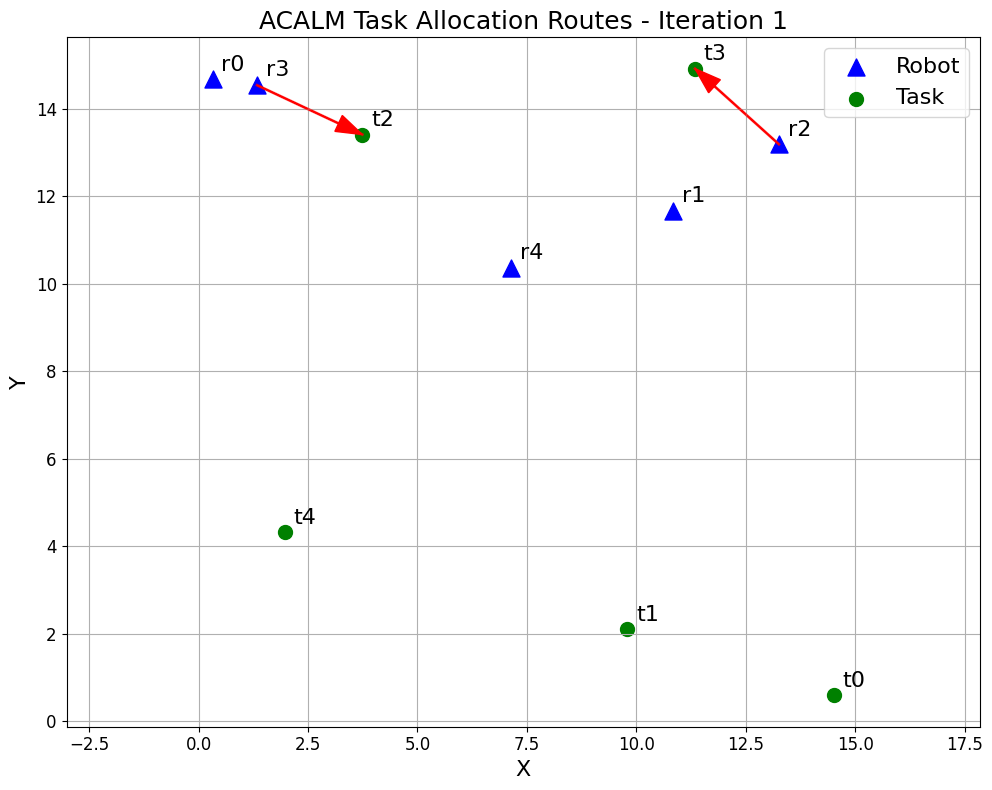

=== Total Distance at Iteration 1: 5.24




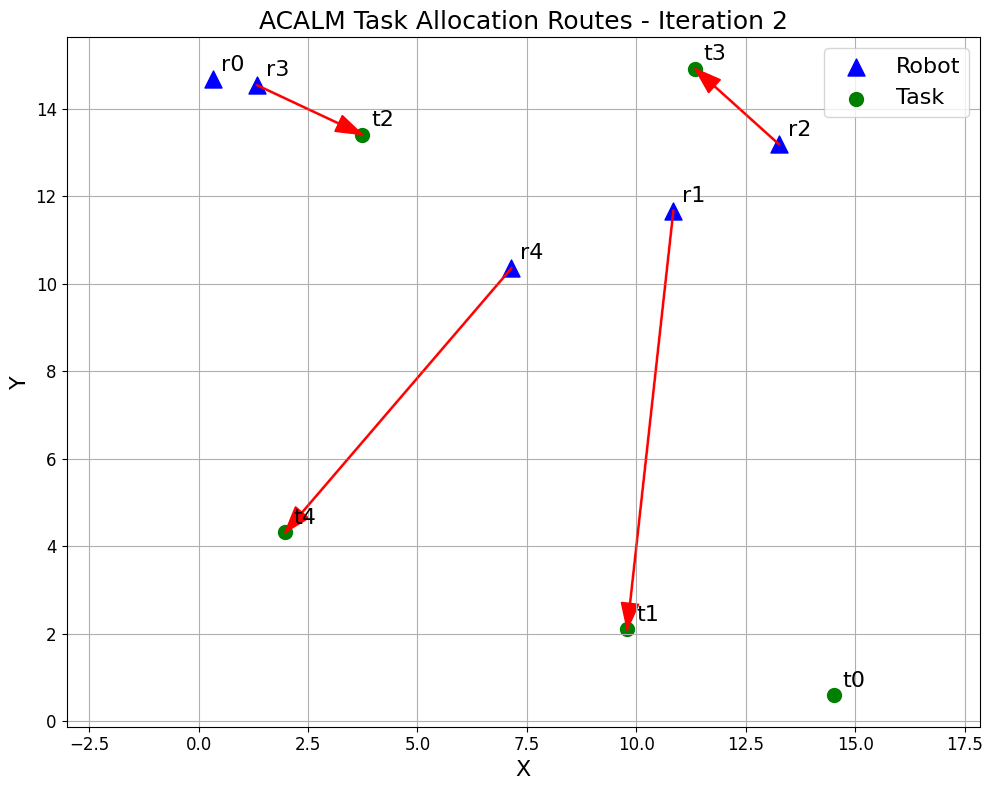

=== Total Distance at Iteration 2: 22.82




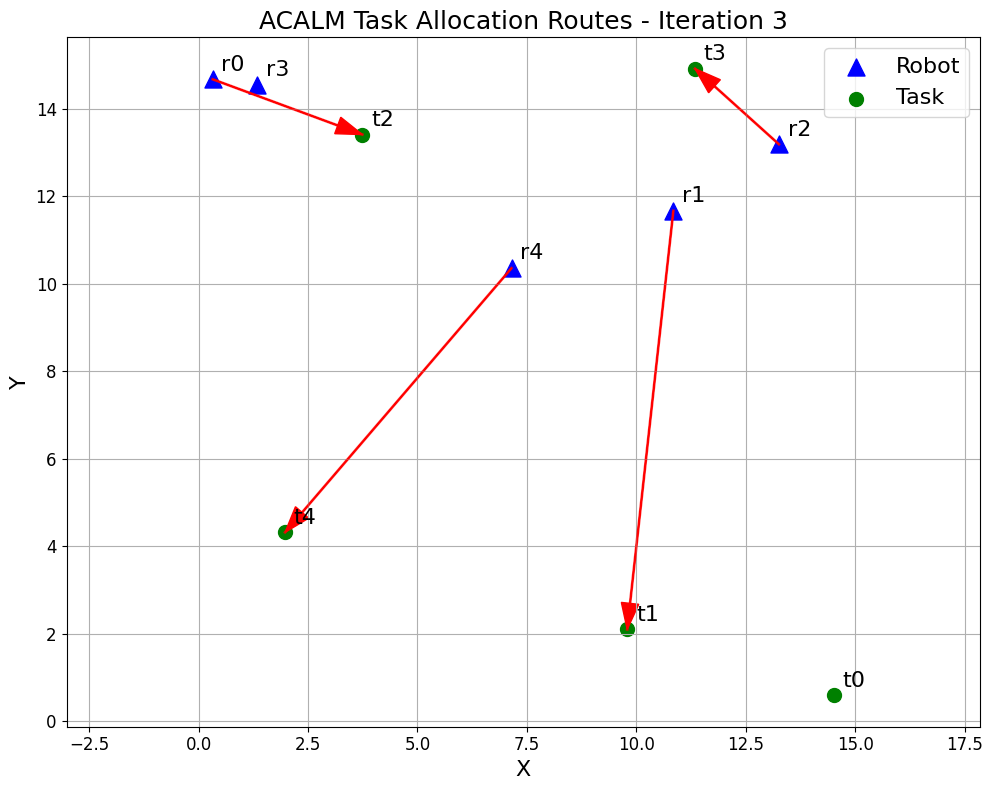

=== Total Distance at Iteration 3: 23.80




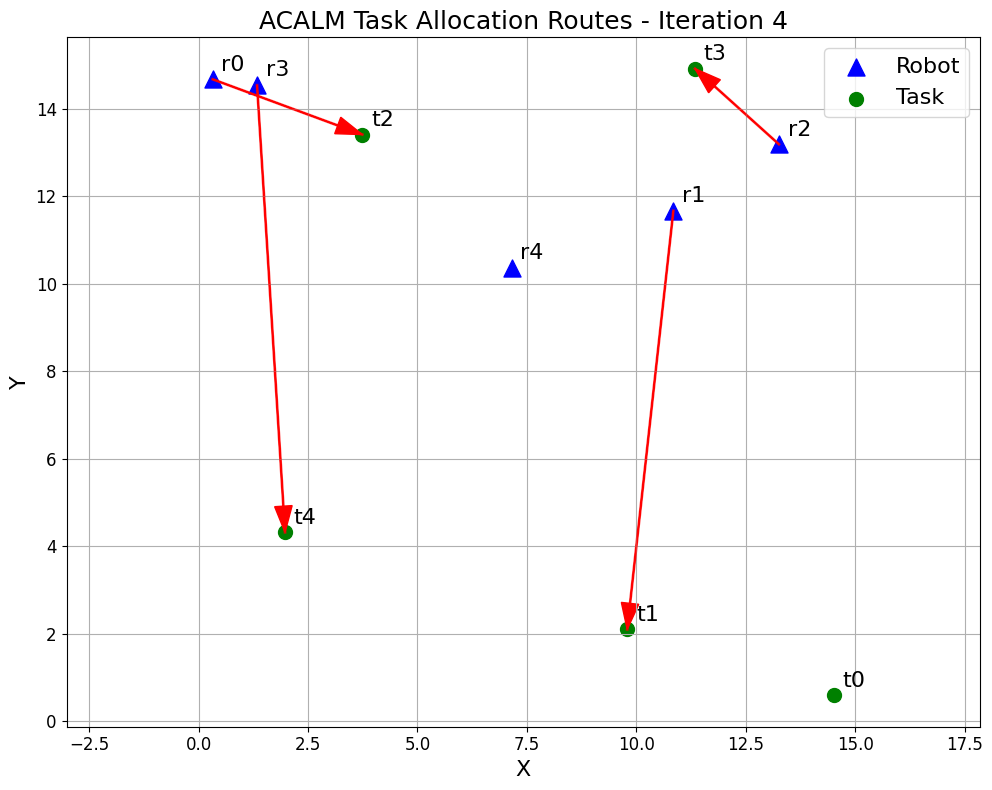

=== Total Distance at Iteration 4: 26.09




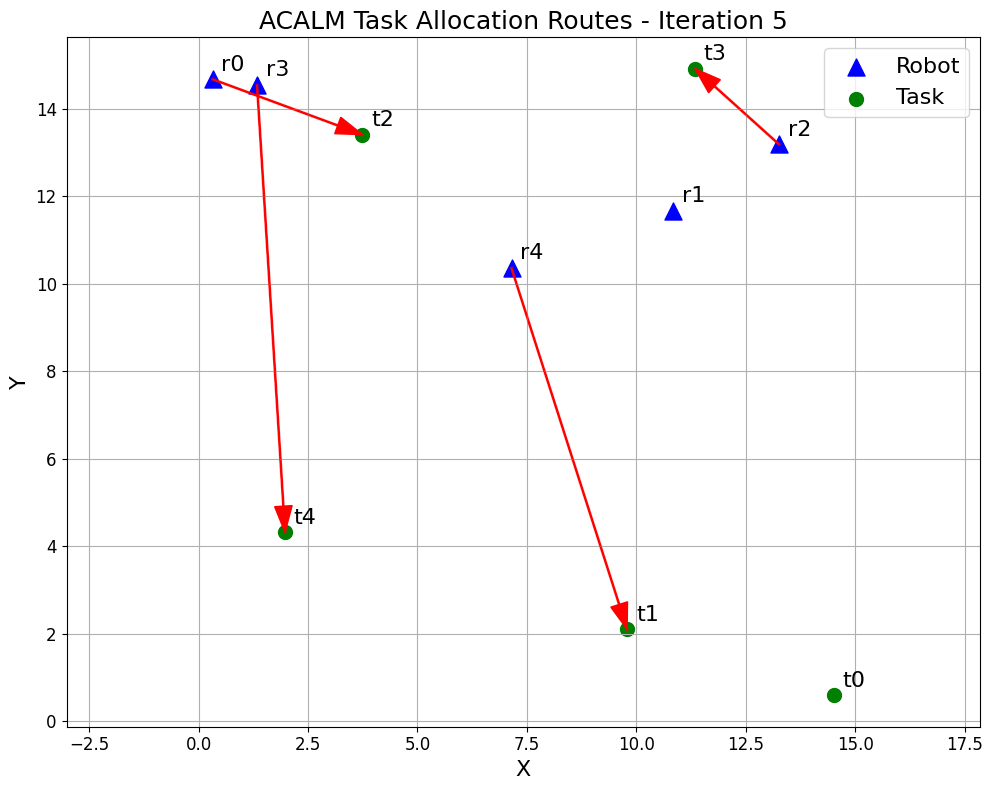

=== Total Distance at Iteration 5: 25.13




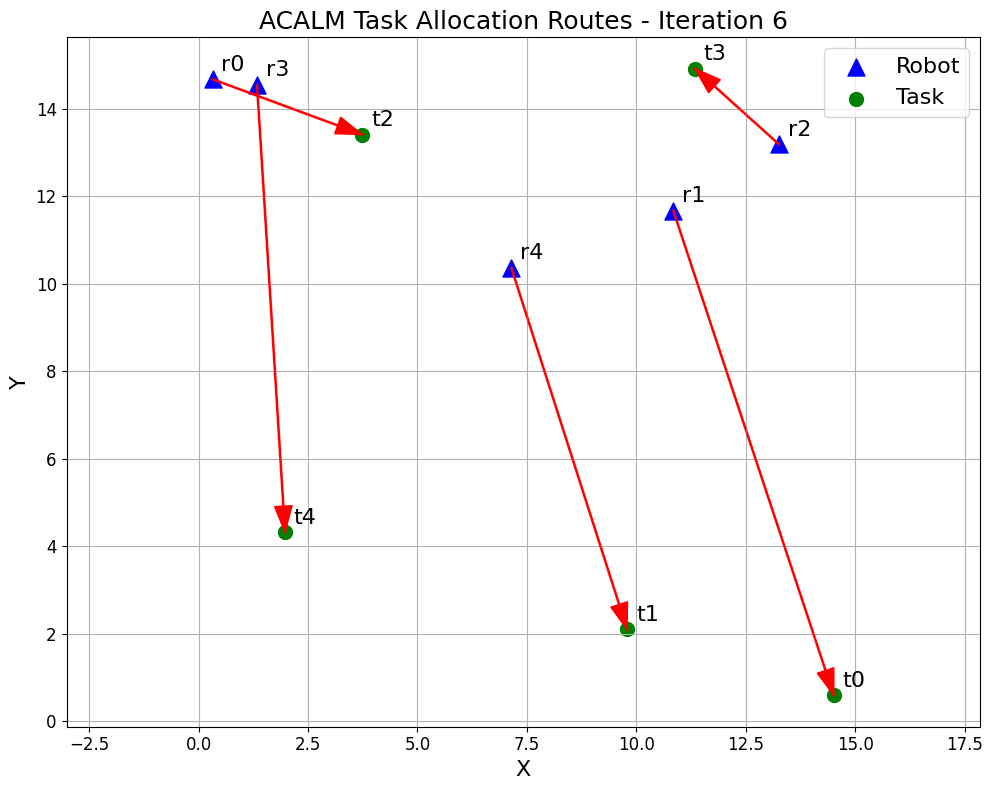

=== Total Distance at Iteration 6: 36.80




In [31]:
tasks = list(task_locations.keys())
drones = list(drone_starts.keys())

# === Extract positions ===
drone_positions = [locations[d] for d in drones]
task_positions = [locations[t] for t in tasks]

print_interval = 1

for step, X_step in enumerate(X_list):
    if step == len(X_list)-1:
        pass
    elif step % print_interval != 0:
        continue


    # === Plot setup ===
    plt.figure(figsize=(10, 8))
    # plt.title("ACALM Task Allocation Routes")
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)

    # Plot drones
    for i, d in enumerate(drones):
        x_pos, y_pos = locations[d]
        plt.scatter(x_pos, y_pos, c='blue', marker='^', s=150, label="Robot" if i == 0 else "")
        plt.text(x_pos + 0.2, y_pos + 0.2, "r"+str(i), fontsize=16)

    # Plot tasks
    for i, t in enumerate(tasks):
        x_pos, y_pos = locations[t]
        plt.scatter(x_pos, y_pos, c='green', marker='o', s=100, label="Task" if i == 0 else "")
        plt.text(x_pos + 0.2, y_pos + 0.2, t, fontsize=16)

    # === Plot paths based on X array ===
    for i in range(len(drones)):
        for j in range(len(tasks)):
            if X_step[i, j] > 0.5:
                start = drones[i]
                end = tasks[j]
                x_coords = [locations[start][0], locations[end][0]]
                y_coords = [locations[start][1], locations[end][1]]
                plt.plot(x_coords, y_coords, 'r-', linewidth=2, alpha=0.7)
                plt.arrow(
                    x_coords[0], y_coords[0],
                    x_coords[1] - x_coords[0],
                    y_coords[1] - y_coords[0],
                    head_width=0.4, head_length=0.6, fc='red', ec='red', length_includes_head=True
                )

    # === Finalize plot ===
    plt.legend(loc='best', fontsize=16)
    plt.grid(True)
    plt.axis('equal')
    plt.tick_params(axis='both', labelsize=12)  # Change to desired size (e.g., 12)
    plt.title(f"ACALM Task Allocation Routes - Iteration {step+1}", fontsize=18)
    plt.tight_layout()
    plt.show()
    print(f"=== Total Distance at Iteration {step+1}: {Total_distance_list[step]:.2f}\n\n")
    